# Networked Life Homework 3

##### Glen Choo 1000472
##### Loo Juin 1000546
##### Tan Hao Qin 1000521

In [19]:
from __future__ import division
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import itertools
%matplotlib inline  
matplotlib.rcParams['figure.figsize'] = (20, 20)

## 1. Baseline predictor

In [21]:
def build_a(r_list):
    a_list = []
    a_row_length = len(r_list) + len(r_list[0])
    movie_base = len(r_list)
    for user_index, _ in enumerate(r_list):
        for movie_offset in range(len(r_list[user_index])):
            movie_index = movie_offset + movie_base
            if r_list[user_index][movie_offset] > 0:
                a_list.append(build_a_row(a_row_length, user_index, movie_index))
    return a_list

def build_a_row(length, i, j):
    return [1 if ele is i or ele is j else 0 for ele in xrange(length)]

def build_c(r_list):
    ratings = [ele for user in r_list for ele in user if ele > 0]
    average = sum(ratings)/len(ratings)
    return [ele - average for ele in ratings]

def solve_b(a_list, c_list):
    a_mat = np.matrix(a_list)
    c_mat = np.matrix(c_list).T
    return np.linalg.inv(a_mat.T * a_mat) * a_mat.T * c_mat

def convert_b(b_mat):
    return [ele[0] for ele in b_mat.tolist()]

def build_r_hat(r_list, b_list):
    r_hat = r_list
    movie_base = len(r_list)
    ratings = [ele for user in r_list for ele in user if ele > 0]

    average = sum(ratings)/len(ratings)

    movie_base = len(r_list)
    for user_index, _ in enumerate(r_list):
        for movie_offset in xrange(len(r_list[user_index])):
            r_hat[user_index][movie_offset] = average + b_list[user_index] + \
            									b_list[movie_offset + movie_base]
    return np.matrix(r_hat)

def get_r_hat(r_list):
    return build_r_hat(r_list, convert_b(solve_b(build_a(r_list), build_c(r_list))))

if __name__ == "__main__":
    R_LIST = [[5, -1, 5, 4],
              [-1, 1, 1, 4],
              [4, 1, 2, 4],
              [3, 4, -1, 3],
              [1, 5, 3, -1]]

    FLOAT_R_LIST = [[float(x) for x in row] for row in R_LIST]
    print get_r_hat(FLOAT_R_LIST)

[[ 4.5       5.125     3.859375  4.734375]
 [ 2.265625  2.890625  1.625     2.5     ]
 [ 2.96875   3.59375   2.328125  3.203125]
 [ 2.921875  3.546875  2.28125   3.15625 ]
 [ 2.671875  3.296875  2.03125   2.90625 ]]


## 2. Neighborhood predictor

In [24]:
INFINITY_VALUE = 100000

def generate_error_matrix(actual_matrix, pred_matrix):
	error_matrix = actual_matrix - pred_matrix
	shape = actual_matrix.shape
	for i in range(shape[0]):
		for j in range(shape[1]):
			if actual_matrix[i, j] == -1:
				error_matrix[i, j] = -INFINITY_VALUE
	return error_matrix


def compute_distance(r1, r2):
	if r1.shape != r2.shape:
		raise Exception("compute_distance: Input shapes do not match.")
	numerator = 0.0
	r1_summer = 0.0
	r2_summer = 0.0
	for i in range(r1.shape[0]):
		left = r1[i, 0]
		right = r2[i, 0]
		if left != -INFINITY_VALUE and right != -INFINITY_VALUE:
			numerator += left * right
			r1_summer += left ** 2
			r2_summer += right ** 2
	return numerator / np.sqrt(r1_summer * r2_summer) if r1_summer != 0 and r2_summer != 0 else 0


class DistanceMachine:
	def __init__(self, error_matrix):
		self.error_matrix = error_matrix
		self.struct = {}

	def get(self, a, b):
		index = (a, b) if b >= a else (b, a)
		try:
			return self.struct[index]
		except KeyError:
			dist = compute_distance(self.error_matrix[:, a], self.error_matrix[:, b])
			self.struct[index] = dist
			return dist


class NeighbourhoodMachine:
	def __init__(self, error_matrix, size):
		if size >= error_matrix.shape[1]:
			raise Exception("NeighbourhoodMachine: Cannot have neighbourhood size equal to or larger than number of movies!")
		self.error_matrix = error_matrix
		self.size = size
		self.dist_machine = DistanceMachine(error_matrix)
		self.struct = {}

	def get(self, i):
		try:
			return self.struct[i]
		except KeyError:
			dists = []
			for j in range(self.error_matrix.shape[1]):
				if j != i:
					dists.append((j, self.dist_machine.get(i, j)))
			dists = sorted(dists, key = lambda k: -np.abs(k[1]))
			# print i, dists
			self.struct[i] = dists[0:self.size]
			return self.struct[i]


def neighbourhood_predict(actual_matrix, pred_matrix, size):
	error_matrix = generate_error_matrix(actual_matrix, pred_matrix)
	nbh_machine = NeighbourhoodMachine(error_matrix, size)
	ret_matrix = np.matrix([[0.0] * pred_matrix.shape[1]] * pred_matrix.shape[0])
	for u in range(pred_matrix.shape[0]):
		for i in range(pred_matrix.shape[1]):
			nbh = nbh_machine.get(i)
			numerator = 0.0
			denominator = 0.0
			for n in nbh:
				if error_matrix[u, n[0]] != -INFINITY_VALUE:
					numerator += n[1] * error_matrix[u, n[0]]
					denominator += np.abs(n[1])
			offset = numerator/denominator if denominator != 0 else 0
			ret_matrix[u, i] = pred_matrix[u, i] + offset
	return ret_matrix


if __name__ == "__main__":
	# actual_matrix = np.matrix([[5, 4, 4, -1, -1],
	# 						   [-1, 3, 5, -1, 4],
	# 						   [5, 2, -1, -1, 3],
	# 						   [-1, -1, 3, 1, 2],
	# 						   [4, -1, -1, 4, 5],
	# 						   [-1, 3, -1, 3, 5],
	# 						   [3, -1, 3, 2, -1],
	# 						   [5, -1, 4, -1, 5],
	# 						   [-1, 2, 5, 4, -1],
	# 						   [-1, -1, 5, 3, 4]])
	actual_matrix = [[5, -1, 5, 4],
					 [-1, 1, 1, 4],
					 [4, 1, 2, 4],
					 [3, 4, -1, 3],
					 [1, 5, 3, -1]]
	print "Actual ratings:"
	print actual_matrix
	# pred_matrix = np.matrix([[5.0, 3.09, 4.90, -1, 4.62],
	# 						 [-1, 2.89, 4.69, 3.49, 4.42],
	# 						 [4.1, 2.19, -1, 2.78, 3.71],
	# 						 [-1, 1.0, 2.49, 1.29, 2.22],
	# 						 [4.9, -1, 4.79, 3.58, 4.51],
	# 						 [4.88, 2.96, -1, 3.56, 4.48],
	# 						 [3.15, 1.23, 3.03, 1.82, -1],
	# 						 [4.84, 2.92, 4.72, -1, 4.44],
	# 						 [4.84, 2.92, 4.72, 3.51, -1],
	# 						 [4.61, -1, 4.49, 3.29, 4.22]])
	pred_matrix = build_r_hat(actual_matrix, convert_b(solve_b(build_a(actual_matrix), build_c(actual_matrix))))
	print "Predicted ratings:"
	print pred_matrix
	offset_matrix = neighbourhood_predict(np.matrix(actual_matrix), pred_matrix, 2)
	print "New predictions:"
	print offset_matrix

Actual ratings:
[[5, -1, 5, 4], [-1, 1, 1, 4], [4, 1, 2, 4], [3, 4, -1, 3], [1, 5, 3, -1]]
Predicted ratings:
[[ 4.5       5.125     3.859375  4.734375]
 [ 2.265625  2.890625  1.625     2.5     ]
 [ 2.96875   3.59375   2.328125  3.203125]
 [ 2.921875  3.546875  2.28125   3.15625 ]
 [ 2.671875  3.296875  2.03125   2.90625 ]]
New predictions:
[[ 4.5       5.125     3.859375  4.734375]
 [ 2.265625  2.890625  1.625     2.5     ]
 [ 2.96875   3.59375   2.328125  3.203125]
 [ 2.921875  3.546875  2.28125   3.15625 ]
 [ 2.671875  3.296875  2.03125   2.90625 ]]


## 3. Least squares
## 3a. Minimise$_b$ $||\textbf{Ab} - \textbf{c}||^2_2$

$$\frac{d||\textbf{Ab} - \textbf{c}||^2_2}{d\textbf{b}} = 0\\
2(\textbf{A}^T\textbf{A}\textbf{b}) - 2\textbf{A}^T\textbf{c} = 0 \\
\textbf{A}^T\textbf{A}\textbf{b} = \textbf{A}^T\textbf{c} \\
\textbf{b} = (\textbf{A}^T\textbf{A})^{-1}\textbf{A}^T\textbf{c} \\
$$



In [4]:
# A - 4 by 3 matrix
# B - 3 by 1 matrix
# C - 4 by 1 matrix

A = [[1,0,2],
	[1,1,0],
	[0,2,1],
	[2,1,1]]

C = [[2],
	[1],
	[1],
	[3]]

A = np.matrix(A)
C = np.matrix(C)

# Solving for A^T*A
ATA = np.transpose(A) * A

# Solving for (A^T*A)^(-1)
ATAinv = np.linalg.inv(ATA)

# Solving for A^T*c
ATC = np.transpose(A) * C

# Solving for b
B = ATAinv * ATC

print B

[[ 1.03571429]
 [ 0.21428571]
 [ 0.53571429]]


## 3b. Minimise$_b$ $||\textbf{Ab} - \textbf{c}||^2_2 + \lambda||\textbf{b}||^2_2$

$$\frac{d(||\textbf{Ab} - \textbf{c}||^2_2+ \lambda||\textbf{b}||^2_2)}{d\textbf{b}} = 0\\
2(\textbf{A}^T\textbf{A}\textbf{b}) - 2\textbf{A}^T\textbf{c} + \lambda \textbf{b} = 0 \\
(\textbf{A}^T\textbf{A} + \lambda/2\textbf{I})\textbf{b} = \textbf{A}^T\textbf{c} \\
\textbf{b} = (\textbf{A}^T\textbf{A} + \lambda/2\textbf{I})^{-1}\textbf{A}^T\textbf{c} \\
$$



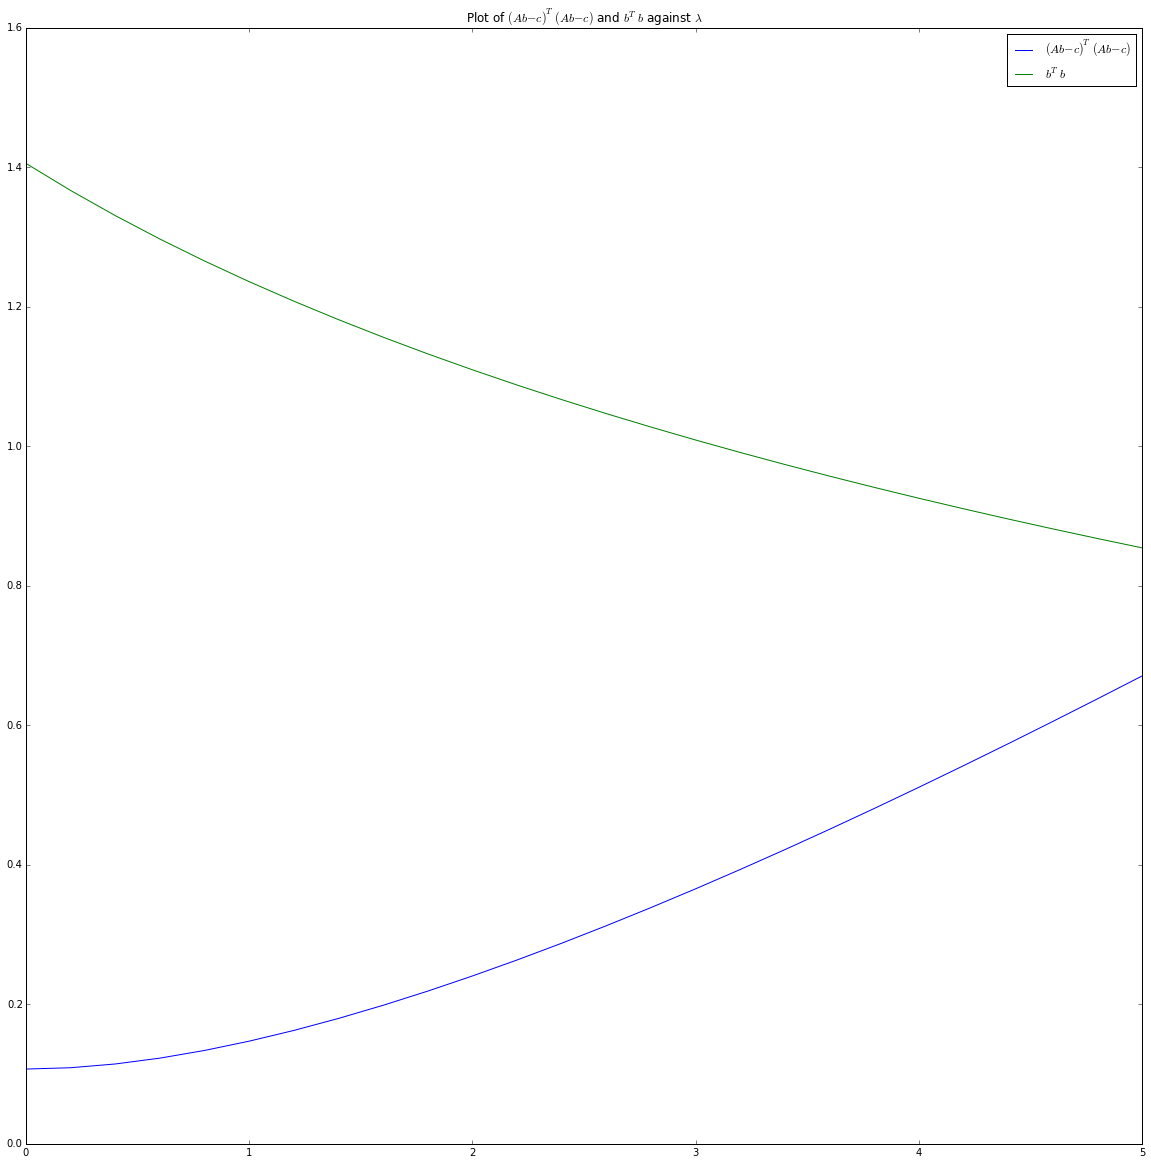

In [20]:
# Generating list of regularization factors
reg_factors = np.arange(0,5.2,0.2)
b_list = []

# Iterating through all lambda from 0.2 to 5.0
for lamda in reg_factors:
    
    # Calculating inverse for (2 A^T * A + lambda/2)
	ATAinv = np.linalg.inv(ATA + (lamda*np.eye(3)/2))
    
    # Calculating b values
	b_list.append(ATAinv * ATC)

# Calculating list for ||Ab - c||^2_2
abcl2 = [float(np.transpose(A*b - C) * (A*b - C)) for b in b_list]
# Calculating list for ||b||^2_2
bl2 = [float(np.transpose(b) * (b)) for b in b_list]

# print b_list

plt.title("Plot of $(Ab - c)^T(Ab - c)$ and $b^Tb$ against $\lambda$")
plt.plot(reg_factors, abcl2)
plt.plot(reg_factors, bl2)
plt.legend(['$(Ab - c)^T(Ab - c)$', '$b^Tb$'])
plt.show()